<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/improvement_Lucia2/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b improvement_Lucia2 https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 2148 (delta 57), reused 0 (delta 0), pack-reused 2053
Receiving objects: 100% (2148/2148), 2.54 MiB | 6.81 MiB/s, done.
Resolving deltas: 100% (1372/1372), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
exemplars = [None]*100

test_indexes =  []
accs = []

At step  0  and at epoch =  0  the loss is =  0.03553874418139458  and accuracy is =  0.1512
At step  0  and at epoch =  1  the loss is =  0.035814277827739716  and accuracy is =  0.3658
At step  0  and at epoch =  2  the loss is =  0.019422875717282295  and accuracy is =  0.4394
At step  0  and at epoch =  3  the loss is =  0.01824834942817688  and accuracy is =  0.504
At step  0  and at epoch =  4  the loss is =  0.02295566536486149  and accuracy is =  0.5522
At step  0  and at epoch =  5  the loss is =  0.02002432383596897  and accuracy is =  0.5826
At step  0  and at epoch =  6  the loss is =  0.019542668014764786  and accuracy is =  0.5884
At step  0  and at epoch =  7  the loss is =  0.01539906021207571  and accuracy is =  0.6504
At step  0  and at epoch =  8  the loss is =  0.022105002775788307  and accuracy is =  0.669
At step  0  and at epoch =  9  the loss is =  0.013011856004595757  and accuracy is =  0.6736
At step  0  and at epoch =  10  the loss is =  0.012887015007436275

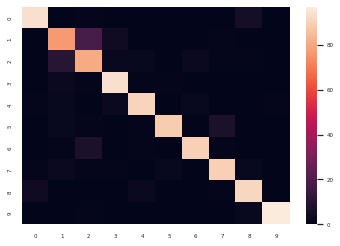

At step  10  and at epoch =  0  the loss is =  0.029056577011942863  and accuracy is =  0.30328571428571427
At step  10  and at epoch =  1  the loss is =  0.028877992182970047  and accuracy is =  0.39
At step  10  and at epoch =  2  the loss is =  0.02777109481394291  and accuracy is =  0.4897142857142857
At step  10  and at epoch =  3  the loss is =  0.0241326205432415  and accuracy is =  0.5358571428571428
At step  10  and at epoch =  4  the loss is =  0.023878006264567375  and accuracy is =  0.5781428571428572
At step  10  and at epoch =  5  the loss is =  0.027481786906719208  and accuracy is =  0.6087142857142858
At step  10  and at epoch =  6  the loss is =  0.02515465021133423  and accuracy is =  0.6307142857142857
At step  10  and at epoch =  7  the loss is =  0.018982505425810814  and accuracy is =  0.6435714285714286
At step  10  and at epoch =  8  the loss is =  0.027352523058652878  and accuracy is =  0.6634285714285715
At step  10  and at epoch =  9  the loss is =  0.02202

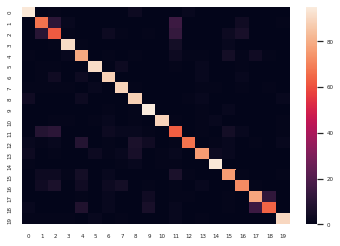

At step  20  and at epoch =  0  the loss is =  0.034325480461120605  and accuracy is =  0.349375
At step  20  and at epoch =  1  the loss is =  0.033642224967479706  and accuracy is =  0.4095
At step  20  and at epoch =  2  the loss is =  0.03419780731201172  and accuracy is =  0.472
At step  20  and at epoch =  3  the loss is =  0.03436579182744026  and accuracy is =  0.537375
At step  20  and at epoch =  4  the loss is =  0.03220774978399277  and accuracy is =  0.57325
At step  20  and at epoch =  5  the loss is =  0.029806895181536674  and accuracy is =  0.6
At step  20  and at epoch =  6  the loss is =  0.029415272176265717  and accuracy is =  0.62325
At step  20  and at epoch =  7  the loss is =  0.028958816081285477  and accuracy is =  0.643
At step  20  and at epoch =  8  the loss is =  0.03406600281596184  and accuracy is =  0.66275
At step  20  and at epoch =  9  the loss is =  0.03416507691144943  and accuracy is =  0.677625
At step  20  and at epoch =  10  the loss is =  0.0

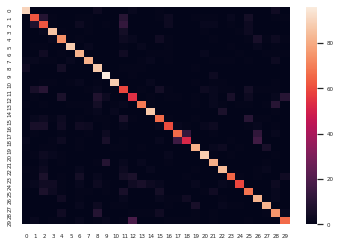

At step  30  and at epoch =  0  the loss is =  0.03921209275722504  and accuracy is =  0.39711649365628604
At step  30  and at epoch =  1  the loss is =  0.038293059915304184  and accuracy is =  0.46608996539792386
At step  30  and at epoch =  2  the loss is =  0.03869814798235893  and accuracy is =  0.5271049596309112
At step  30  and at epoch =  3  the loss is =  0.03321243077516556  and accuracy is =  0.5604382929642445
At step  30  and at epoch =  4  the loss is =  0.03496675193309784  and accuracy is =  0.5945790080738178
At step  30  and at epoch =  5  the loss is =  0.03481946513056755  and accuracy is =  0.6035755478662053
At step  30  and at epoch =  6  the loss is =  0.03521040827035904  and accuracy is =  0.6243367935409458
At step  30  and at epoch =  7  the loss is =  0.03130773454904556  and accuracy is =  0.6450980392156863
At step  30  and at epoch =  8  the loss is =  0.035456202924251556  and accuracy is =  0.6517877739331026
At step  30  and at epoch =  9  the loss i

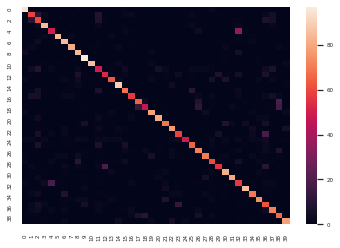

At step  40  and at epoch =  0  the loss is =  0.05045821890234947  and accuracy is =  0.40806979280261724
At step  40  and at epoch =  1  the loss is =  0.046041637659072876  and accuracy is =  0.4451472191930207
At step  40  and at epoch =  2  the loss is =  0.044134341180324554  and accuracy is =  0.48833151581243184
At step  40  and at epoch =  3  the loss is =  0.04091155156493187  and accuracy is =  0.521701199563795
At step  40  and at epoch =  4  the loss is =  0.04156788811087608  and accuracy is =  0.5411123227917121
At step  40  and at epoch =  5  the loss is =  0.04542053863406181  and accuracy is =  0.5687022900763359
At step  40  and at epoch =  6  the loss is =  0.0426415354013443  and accuracy is =  0.5899672846237731
At step  40  and at epoch =  7  the loss is =  0.051304012537002563  and accuracy is =  0.6030534351145038
At step  40  and at epoch =  8  the loss is =  0.04689464345574379  and accuracy is =  0.6187568157033806
At step  40  and at epoch =  9  the loss is

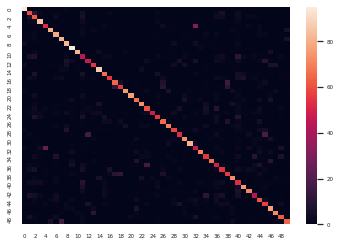

At step  50  and at epoch =  0  the loss is =  0.05230920761823654  and accuracy is =  0.41243469174503655
At step  50  and at epoch =  1  the loss is =  0.05095735564827919  and accuracy is =  0.470846394984326
At step  50  and at epoch =  2  the loss is =  0.04795372113585472  and accuracy is =  0.5174503657262278
At step  50  and at epoch =  3  the loss is =  0.04589647427201271  and accuracy is =  0.5431556948798328
At step  50  and at epoch =  4  the loss is =  0.047950629144907  and accuracy is =  0.5700104493207941
At step  50  and at epoch =  5  the loss is =  0.049517422914505005  and accuracy is =  0.5824451410658307
At step  50  and at epoch =  6  the loss is =  0.051253125071525574  and accuracy is =  0.6055381400208987
At step  50  and at epoch =  7  the loss is =  0.048239994794130325  and accuracy is =  0.6106583072100313
At step  50  and at epoch =  8  the loss is =  0.0443805567920208  and accuracy is =  0.61901776384535
At step  50  and at epoch =  9  the loss is =  0

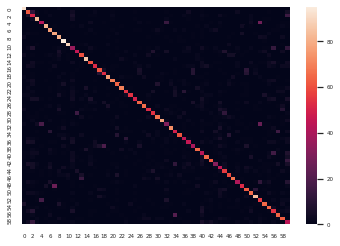

At step  60  and at epoch =  0  the loss is =  0.055877935141325  and accuracy is =  0.41494949494949496
At step  60  and at epoch =  1  the loss is =  0.05757898464798927  and accuracy is =  0.4616161616161616
At step  60  and at epoch =  2  the loss is =  0.06488163024187088  and accuracy is =  0.49444444444444446
At step  60  and at epoch =  3  the loss is =  0.05413069948554039  and accuracy is =  0.5197979797979798
At step  60  and at epoch =  4  the loss is =  0.05270574614405632  and accuracy is =  0.5366666666666666
At step  60  and at epoch =  5  the loss is =  0.058674637228250504  and accuracy is =  0.5526262626262626
At step  60  and at epoch =  6  the loss is =  0.05706387758255005  and accuracy is =  0.573939393939394
At step  60  and at epoch =  7  the loss is =  0.05389115959405899  and accuracy is =  0.5791919191919191
At step  60  and at epoch =  8  the loss is =  0.05350618436932564  and accuracy is =  0.5908080808080808
At step  60  and at epoch =  9  the loss is = 

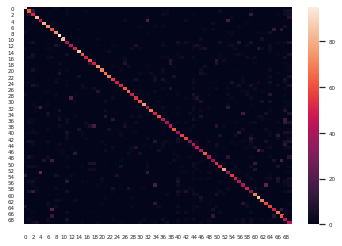

At step  70  and at epoch =  0  the loss is =  0.06713707745075226  and accuracy is =  0.41030421982335624
At step  70  and at epoch =  1  the loss is =  0.06349731981754303  and accuracy is =  0.4929342492639843
At step  70  and at epoch =  2  the loss is =  0.05691636726260185  and accuracy is =  0.5524043179587831
At step  70  and at epoch =  3  the loss is =  0.055807217955589294  and accuracy is =  0.5788027477919528
At step  70  and at epoch =  4  the loss is =  0.058765679597854614  and accuracy is =  0.5996074582924436
At step  70  and at epoch =  5  the loss is =  0.060603950172662735  and accuracy is =  0.6157998037291462
At step  70  and at epoch =  6  the loss is =  0.06140134111046791  and accuracy is =  0.6245338567222768
At step  70  and at epoch =  7  the loss is =  0.05968040972948074  and accuracy is =  0.6371933267909715
At step  70  and at epoch =  8  the loss is =  0.0571315735578537  and accuracy is =  0.6580961727183513
At step  70  and at epoch =  9  the loss is

In [ ]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
      tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()

In [ ]:
accs = [.897,.80,.76,.69,.64,.58,.54,.52,.48,.46]

In [ ]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plotTask(pars_tasks):

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy'])
  plt.xlabel("Epoch")
  plt.ylim(0,1)
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy'])
  plt.grid(True)
  plt.show()

In [ ]:
plotTask(accs)

In [ ]:
np.diagonal(cf)

In [ ]:
true = np.sum(cf, axis=1)
true

In [ ]:
pred = np.sum(cf, axis=0)
pred

In [ ]:
pred = np.array([137,  98, 142, 112,  39,  82, 116,  96, 145, 112,  84, 110,  59,
        96,  73,  78,  50,  91,  98,  92,  64, 109,  91,  72,  38,  70,
        76,  81,  89, 102,  81, 116,  72,  59, 177,  59,  62,  63,  93,
        90,  72,  79, 102,  52, 162,  68,  67,  80,  65,  98,  80,  65,
        84,  96, 121,  53,  77, 136,  69, 103,  76,  94, 109,  79, 126,
        61, 126, 106, 182,  68, 122,  94,  90,  80,  80, 159,  98, 132,
       145,  88, 170,  77,  79,  78, 131,  74, 149,  70, 149, 114, 102,
       172, 212, 134, 124, 187, 189, 114, 126, 131])

In [ ]:
i = 0
for el, name in zip(pred,trainDS.__getClassesNames__()) :
  print('classe', i, 'name', name, ',preds', el)
  i+=1

In [ ]:
train_splits

In [ ]:
trainDS.__getClassesNames__()